<a href="https://colab.research.google.com/github/gracekazmierski/machinelearning/blob/main/bank-marketing-campaign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Imports
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, \
                             precision_recall_curve, make_scorer, f1_score, precision_score, recall_score
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import pickle
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import seaborn as sns

df = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bank.csv')

In [ ]:
print(df.isnull().sum())
print(df.tail())

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64
       age          job  marital            education default housing loan  \
37064   73      retired  married  professional.course      no     yes   no   
37065   46  blue-collar  married  professional.course      no      no   no   
37066   56      retired  married    university.degree      no     yes   no   
37067   44   technician  married  professional.course      no      no   no   
37068   74      retired  married  professional.course      no     yes   no   

        contact month day_of_week  campaign  pdays  previous     poutcome  \
37064  cellular   nov         fri        

In [ ]:
df['y'].value_counts()

,count
y,
no,32861
yes,4208


In [ ]:
# Initial data cleaning
df.replace("unknown", pd.NA, inplace=True)
df.fillna(df.mode().iloc[0], inplace=True)

# Replace 'never contacted'
df['pdays'].value_counts()
df['pdays'] = df['pdays'].replace(999, -1)

# Map education to numerics
education_mapping = {
  "illiterate" : 0
  ,"basic.4y" : 4
  ,"basic.6y" : 6
  ,"basic.9y" : 9
  ,"high.school" : 12
  ,"professional.course" : 13
  ,"university.degree" : 16
  ,"unknown" : -1
}
df["education"] = df["education"].replace(education_mapping)

categorical_columns = [
    "job", "marital", "default", "housing", "loan",
    "contact", "month", "day_of_week", "poutcome",
]

# One-hot encode
df_clean = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

<ipython-input-4-16ab290bcdda>:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["education"] = df["education"].replace(education_mapping)


In [ ]:
df_clean.dtypes

,0
age,int64
education,int64
campaign,int64
pdays,int64
previous,int64
emp.var.rate,float64
cons.price.idx,float64
cons.conf.idx,float64
euribor3m,float64
nr.employed,float64


In [ ]:
# Split the data
df_clean["y"] = df_clean["y"].replace({"no": 0, "yes": 1}).astype(int)
X = df_clean.drop('y', axis=1)
y = df_clean['y']

<ipython-input-6-4c94253db700>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean["y"] = df_clean["y"].replace({"no": 0, "yes": 1}).astype(int)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Initializes a standard scaler for numerical features.
# The ColumnTransformer is set up to apply StandardScaler to all columns of the input data X, and it will keep all columns in the output
numeric_transformer = StandardScaler()
scale_features = X.columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', numeric_transformer, scale_features)
    ],
    remainder='passthrough' # any columns not included should be kept without modification
)

In [ ]:
rf_model = RandomForestClassifier(random_state=42)
pipeline_smote = ImbPipeline(steps=[('preprocessor', preprocessor),
                                     ('smote', SMOTE(random_state=42)),
                                    ('classifier', rf_model)])

The pipeline consists of three steps:
1. 'preprocessor': Applies the defined preprocessor (which scales features).
2. 'smote': Applies the SMOTE technique to oversample the minority class.
3. 'classifier': Uses the initialized RandomForestClassifier for modeling.

In [ ]:
f1_positive_scorer = make_scorer(f1_score, pos_label=1)
recall_positive_scorer = make_scorer(recall_score, pos_label=1)
precision_positive_scorer = make_scorer(precision_score, pos_label=1)
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

Defines custom evaluation metrics (F1, Recall, Precision) specifically for the positive class (label 1) and sets up a 3-fold stratified cross-validation strategy to ensure balanced splits of the data across folds
This trains the model on two groups and tests on the third, repeating this process three times so each group gets a turn being the test set.

In [ ]:
param_dist_rf = {
    'classifier__n_estimators': [100, 150, 200], # number of trees in forest
    'classifier__max_depth': [10, 20, 30, None], #max depth of each tree
    'classifier__min_samples_split': randint(2, 11), # minimum number of samples to split
    'classifier__min_samples_leaf': randint(1, 5), # minimum number samples needed to be a leaf
    'classifier__class_weight': ['balanced', None]
}

random_search_smote = RandomizedSearchCV(
    estimator=pipeline_smote,
    param_distributions=param_dist_rf,
    n_iter=10, # Number of parameter settings that are sampled
    scoring={'f1_pos': f1_positive_scorer, 'recall_pos': recall_positive_scorer, 'precision_pos': precision_positive_scorer},
    refit='f1_pos', # explains which metric to used (i.e. the best one)
    cv=skf,    # Can still use the StratifiedKFold object
    n_jobs=-1, # number of tasks running
    verbose=2, #displays more detailed metrics
    random_state=42
)

print("Starting RandomizedSearchCV with SMOTE...")
random_search_smote.fit(X_train, y_train)

best_pipeline_instance = random_search_smote.best_estimator_ # Estimator that was chosen by the search
best_hyperparameters = random_search_smote.best_params_ # Hyperperameters chosen by search
best_cv_score = random_search_smote.best_score_ # best cross-validation score

print(f"\nBest parameters found (with SMOTE): {best_hyperparameters}")
print(f"Best F1 score for positive class (with SMOTE) on CV: {best_cv_score:.4f}")

y_pred = best_pipeline_instance.predict(X_test)

Starting RandomizedSearchCV with SMOTE...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best parameters found (with SMOTE): {'classifier__class_weight': None, 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 9, 'classifier__n_estimators': 150}
Best F1 score for positive class (with SMOTE) on CV: 0.5007


In [ ]:
# test without SMOTE, using the same parameters before
pipeline_class_weight = ImbPipeline(steps=[('preprocessor', preprocessor),
                                           ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))])

param_dist_cw = {
     'classifier__n_estimators': [100, 150, 200],
     'classifier__max_depth': [10, 20, 30, None],
     'classifier__min_samples_split': randint(2, 11),
     'classifier__min_samples_leaf': randint(1, 5),
}

random_search_cw = RandomizedSearchCV(
     estimator=pipeline_class_weight,
     param_distributions=param_dist_cw,
     n_iter=10,
     scoring={'f1_pos': f1_positive_scorer, 'recall_pos': recall_positive_scorer, 'precision_pos': precision_positive_scorer},
     refit='f1_pos',
     cv=skf,
     n_jobs=-1,
     verbose=2,
     random_state=42
)
print("\nStarting RandomizedSearchCV with class_weight='balanced'...")
random_search_cw.fit(X_train, y_train)


Starting RandomizedSearchCV with class_weight='balanced'...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('scaler',
                                                                               StandardScaler(),
                                                                               ['age',
                                                                                'education',
                                                                                'campaign',
                                                                                'pdays',
                                                                                'previous',
                                                                                'emp.var.rate',
                                                                                'cons.price.idx',
                                                                                'cons.conf.idx',
                                                                                'euribor3m',
                                                                                'nr.employed',
                                                                                'job_blue-collar',
                                                                                'job_...
                                        'classifier__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7abb1645d2d0>,
                                        'classifier__n_estimators': [100, 150,
                                                                     200]},
                   random_state=42, refit='f1_pos',
                   scoring={'f1_pos': make_scorer(f1_score, response_method='predict', pos_label=1),
                            'precision_pos': make_scorer(precision_score, response_method='predict', pos_label=1),
                            'recall_pos': make_scorer(recall_score, response_method='predict', pos_label=1)},
                   verbose=2)

In [ ]:
best_model_cw = random_search_cw.best_estimator_
print(f"\nBest parameters found (with class_weight='balanced'): {random_search_cw.best_params_}")
print(f"Best F1 score for positive class (with class_weight='balanced') on CV: {random_search_cw.best_score_:.4f}")


Best parameters found (with class_weight='balanced'): {'classifier__max_depth': None, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 9, 'classifier__n_estimators': 200}
Best F1 score for positive class (with class_weight='balanced') on CV: 0.4997


In [ ]:
if random_search_cw.best_score_ > random_search_smote.best_score_:
    # If the Class Weight model was better
    best_model = random_search_cw.best_estimator_ # Use the best model from the CW search
    chosen_model_name = "Class Weight + RF"
    print(f"\n--- Evaluating {chosen_model_name} Model ---")
else:
    # If the SMOTE model was better or they were equal
    best_model = random_search_smote.best_estimator_ # Use the best model from the SMOTE search
    chosen_model_name = "SMOTE + RF"
    print(f"\n--- Evaluating {chosen_model_name} Model ---")

y_pred_test = best_model.predict(X_test) # generate predictions for unseen data
y_proba_test = best_model.predict_proba(X_test)[:, 1] # generate probabilities for the positive class
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred_test, target_names=['No Subscription', 'Subscription']))

cm = confusion_matrix(y_test, y_pred_test)
print(cm)
print(f"AUC Score on Test Set: {roc_auc_score(y_test, y_proba_test):.4f}")


--- Evaluating SMOTE + RF Model ---

Classification Report on Test Set:
                 precision    recall  f1-score   support

No Subscription       0.94      0.91      0.93      6572
   Subscription       0.45      0.57      0.50       842

       accuracy                           0.87      7414
      macro avg       0.70      0.74      0.71      7414
   weighted avg       0.89      0.87      0.88      7414

[[5982  590]
 [ 362  480]]
AUC Score on Test Set: 0.7983


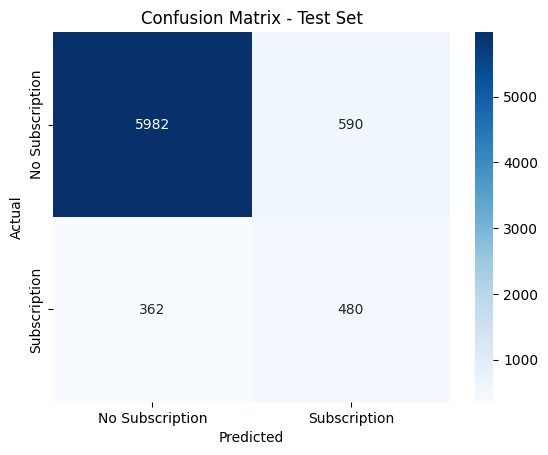

In [ ]:
# visualized cm
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Subscription', 'Subscription'], yticklabels=['No Subscription', 'Subscription'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Test Set')
plt.show()

In [ ]:
# initialize variables
f1_scores_thresh = []
candidate_thresholds = np.linspace(0.05, 0.95, 19) # range to test
best_f1 = -1
best_threshold = 0.5
# loop through the thresholds
for thresh in candidate_thresholds:
  # generates predictions
    y_pred_custom_thresh = (y_proba_test >= thresh).astype(int)

    # evaluates the threshold
    f1 = f1_score(y_test, y_pred_custom_thresh, pos_label=1)
    prec = precision_score(y_test, y_pred_custom_thresh, pos_label=1, zero_division=0)
    rec = recall_score(y_test, y_pred_custom_thresh, pos_label=1, zero_division=0)

    # print all thresholds & the best threshold
    print(f"Threshold: {thresh:.2f} -> Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = thresh

Threshold: 0.05 -> Precision: 0.1136, Recall: 1.0000, F1: 0.2040
Threshold: 0.10 -> Precision: 0.1189, Recall: 0.9857, F1: 0.2122
Threshold: 0.15 -> Precision: 0.1325, Recall: 0.9525, F1: 0.2327
Threshold: 0.20 -> Precision: 0.1530, Recall: 0.8943, F1: 0.2612
Threshold: 0.25 -> Precision: 0.1834, Recall: 0.8147, F1: 0.2994
Threshold: 0.30 -> Precision: 0.2431, Recall: 0.7458, F1: 0.3667
Threshold: 0.35 -> Precision: 0.3073, Recall: 0.6722, F1: 0.4218
Threshold: 0.40 -> Precision: 0.3801, Recall: 0.6176, F1: 0.4706
Threshold: 0.45 -> Precision: 0.4353, Recall: 0.5950, F1: 0.5028
Threshold: 0.50 -> Precision: 0.4486, Recall: 0.5701, F1: 0.5021
Threshold: 0.55 -> Precision: 0.4599, Recall: 0.5451, F1: 0.4989
Threshold: 0.60 -> Precision: 0.4818, Recall: 0.5190, F1: 0.4997
Threshold: 0.65 -> Precision: 0.5145, Recall: 0.4834, F1: 0.4985
Threshold: 0.70 -> Precision: 0.5473, Recall: 0.4264, F1: 0.4793
Threshold: 0.75 -> Precision: 0.5839, Recall: 0.3183, F1: 0.4120
Threshold: 0.80 -> Precis

In [ ]:
# use the best threshold to train the model
print(f"Best Threshold: {best_threshold:.2f} (based on F1 score)")
y_pred_final = (y_proba_test >= best_threshold).astype(int)

# print the best model's cm
print(classification_report(y_test, y_pred_final, target_names=['No Subscription', 'Subscription']))
print(confusion_matrix(y_test, y_pred_final))

Best Threshold: 0.45 (based on F1 score)
                 precision    recall  f1-score   support

No Subscription       0.95      0.90      0.92      6572
   Subscription       0.44      0.60      0.50       842

       accuracy                           0.87      7414
      macro avg       0.69      0.75      0.71      7414
   weighted avg       0.89      0.87      0.88      7414

[[5922  650]
 [ 341  501]]


In [ ]:
# define file names
best_model_filename = 'best_trained_pipeline.pkl'
optimal_threshold_filename = 'optimal_classification_threshold.pkl'

try:
    # opens file in 'wb' mode (write binary)
    with open(best_model_filename, 'wb') as f:
        # serializes python object and writes it to the open file (f)
        pickle.dump(best_model, f)
    print(f"Saved: {best_model_filename}")
except NameError:
    print("'The variable ''best_model' was not defined.")

# repeats the process with the optimal threshold
try:
    with open(optimal_threshold_filename, 'wb') as f:
        pickle.dump(best_threshold, f)
    print(f"({best_threshold:.2f}) saved to {optimal_threshold_filename}")
except NameError:
    print("'best_threshold' was not defined.")

Saved: best_trained_pipeline.pkl
(0.45) saved to optimal_classification_threshold.pkl


In [ ]:
best_model_filename = 'best_trained_pipeline.pkl'
optimal_threshold_filename = 'optimal_classification_threshold.pkl'

# initialized variables
loaded_pipeline = None
loaded_threshold = None

try:
    with open(best_model_filename, 'rb') as f:
        # loads the pipeline
        loaded_pipeline = pickle.load(f)
    print(f"Success: Pipeline loaded from {best_model_filename}")
except FileNotFoundError:
    print(f"{best_model_filename} was not found.")

try:
    with open(optimal_threshold_filename, 'rb') as f:
      # loads the threshold
        loaded_threshold = pickle.load(f)
    print(f"Success: Threshold ({loaded_threshold:.2f}) loaded from {optimal_threshold_filename}")
except FileNotFoundError:
    print(f"{optimal_threshold_filename} was not found.")

model = loaded_pipeline.named_steps['classifier']

Success: Pipeline loaded from best_trained_pipeline.pkl
Success: Threshold (0.45) loaded from optimal_classification_threshold.pkl


In [ ]:
# load and test using loaded model and threshold
y_proba_test = loaded_pipeline.predict_proba(X_test)[:, 1]
y_pred_final = (y_proba_test >= loaded_threshold).astype(int)

print(f"Threshold: {loaded_threshold:.2f}")
print("\nConfusion Matrix on Test Set with Custom Threshold:")
print(confusion_matrix(y_test, y_pred_final))
print("\nClassification Report on Test Set with Custom Threshold:")
print(classification_report(y_test, y_pred_final, target_names=['No Subscription', 'Subscription']))

Threshold: 0.45

Confusion Matrix on Test Set with Custom Threshold:
[[5922  650]
 [ 341  501]]

Classification Report on Test Set with Custom Threshold:
                 precision    recall  f1-score   support

No Subscription       0.95      0.90      0.92      6572
   Subscription       0.44      0.60      0.50       842

       accuracy                           0.87      7414
      macro avg       0.69      0.75      0.71      7414
   weighted avg       0.89      0.87      0.88      7414



In [ ]:
# retrieves and saves actual trained model
model = loaded_pipeline.named_steps['classifier']

# run feature importances
importances = model.feature_importances_
# accesses the 'preprocessor' to retrieve names of features after being processed
feature_names = loaded_pipeline.named_steps['preprocessor'].get_feature_names_out()
# creates a series of importances
feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print("\nFeature Importances:")
print(feature_importances)


Feature Importances:
scaler__euribor3m               0.158411
scaler__nr.employed             0.127126
scaler__emp.var.rate            0.099094
scaler__campaign                0.087961
scaler__contact_telephone       0.064574
scaler__housing_yes             0.064275
scaler__cons.conf.idx           0.058522
scaler__cons.price.idx          0.045215
scaler__month_may               0.037738
scaler__pdays                   0.035594
scaler__education               0.035533
scaler__poutcome_success        0.020628
scaler__age                     0.016988
scaler__poutcome_nonexistent    0.014818
scaler__day_of_week_mon         0.014629
scaler__previous                0.013443
scaler__marital_married         0.013360
scaler__loan_yes                0.012756
scaler__marital_single          0.011222
scaler__month_oct               0.011064
scaler__day_of_week_thu         0.008313
scaler__day_of_week_wed         0.008307
scaler__job_blue-collar         0.008298
scaler__day_of_week_tue         0.0

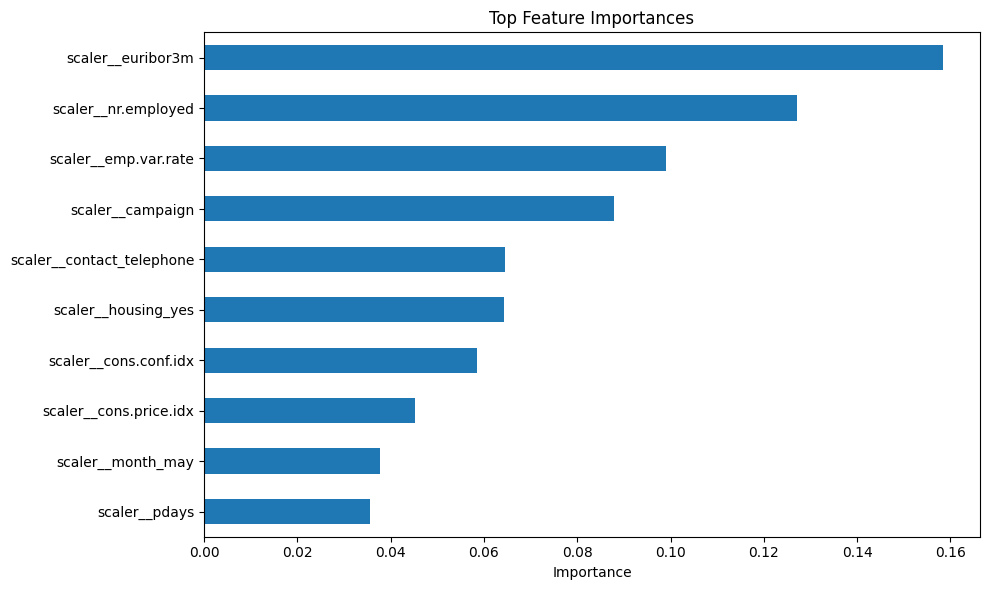

In [ ]:
# plot feature importances
plt.figure(figsize=(10, 6))
feature_importances.head(10).plot(kind='barh')
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.title('Top Feature Importances')
plt.tight_layout()
plt.show()

In [ ]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous',
       'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [ ]:
# percentage subscription rate by job
df["y"] = df["y"].replace({"no": 0, "yes": 1}).astype(int)
print("\nSubscription Rate by Job Category:")
job_subscription_rates = df.groupby('job')['y'].mean()
print(job_subscription_rates.sort_values(ascending=False))


Subscription Rate by Job Category:
job
student          0.313997
retired          0.252282
unemployed       0.146769
admin.           0.130906
management       0.114426
technician       0.108638
self-employed    0.107535
housemaid        0.099792
entrepreneur     0.086391
services         0.082582
blue-collar      0.068195
Name: y, dtype: float64


<ipython-input-24-07dedcbd01e7>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["y"] = df["y"].replace({"no": 0, "yes": 1}).astype(int)


In [ ]:
# percentage subscription rate by marital status
print("\nSubscription Rate by Marital Status Category:")
job_subscription_rates = df.groupby('marital')['y'].mean()
print(job_subscription_rates.sort_values(ascending=False))


Subscription Rate by Marital Status Category:
marital
single      0.140730
divorced    0.106193
married     0.102286
Name: y, dtype: float64


In [ ]:
# subscription rate by education
print("\nSubscription Rate by Education Category:")
job_subscription_rates = df.groupby('education')['y'].mean()
print(job_subscription_rates.sort_values(ascending=False))


Subscription Rate by Education Category:
education
0     0.250000
16    0.140260
13    0.113876
12    0.109890
4     0.102550
6     0.081172
9     0.077022
Name: y, dtype: float64


In [ ]:
# subscription rate by contact status
print("\nSubscription Rate by Contact Status Category:")
job_subscription_rates = df.groupby('contact')['y'].mean()
print(job_subscription_rates.sort_values(ascending=False))


Subscription Rate by Contact Status Category:
contact
cellular     0.148671
telephone    0.052531
Name: y, dtype: float64


In [ ]:
# subscription rate by number of contacts
print("\nSubscription Rate by Number of Contacts (Campaign):")
campaign_rates = df.groupby('campaign')['y'].mean()
print(campaign_rates.head(10))


Subscription Rate by Number of Contacts (Campaign):
campaign
1     0.131347
2     0.113879
3     0.110325
4     0.095038
5     0.076117
6     0.078363
7     0.066190
8     0.041322
9     0.064151
10    0.053140
Name: y, dtype: float64


In [ ]:
# subscritpion by number of contacts (binned)
print("\nSubscription Rate by Binned Campaign (Number of Contacts):")
campaign_bins = [0, 1, 5, 10, 20, df['campaign'].max()]
campaign_labels = ['1', '2-5', '6-10', '11-20', '20+']

df['campaign_bin'] = pd.cut(df['campaign'], bins=campaign_bins, labels=campaign_labels, right=True, include_lowest=True)

binned_campaign_rates = df.groupby('campaign_bin')['y'].mean()

print(binned_campaign_rates)

df = df.drop('campaign_bin', axis=1)


Subscription Rate by Binned Campaign (Number of Contacts):
campaign_bin
1        0.131347
2-5      0.107497
6-10     0.065362
11-20    0.036050
20+      0.000000
Name: y, dtype: float64


<ipython-input-29-333d3c606d06>:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_campaign_rates = df.groupby('campaign_bin')['y'].mean()


In [ ]:
# load in holdout dataset
holdout_url = 'https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bank_holdout_test.csv'
df_holdout = pd.read_csv(holdout_url)

df_holdout.head()
df_holdout.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous',
       'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed'],
      dtype='object')

In [ ]:
# apply same cleaning
df_holdout.replace("unknown", pd.NA, inplace=True)
df_holdout.fillna(df.mode().iloc[0], inplace=True)

df_holdout['pdays'].value_counts()
df_holdout['pdays'] = df_holdout['pdays'].replace(999, -1)

education_mapping = {
  "illiterate" : 0
  ,"basic.4y" : 4
  ,"basic.6y" : 6
  ,"basic.9y" : 9
  ,"high.school" : 12
  ,"professional.course" : 13
  ,"university.degree" : 16
  ,"unknown" : -1
}
df_holdout["education"] = df["education"].replace(education_mapping)

categorical_columns = [
    "job", "marital", "default", "housing", "loan",
    "contact", "month", "day_of_week", "poutcome",
]

df_holdout = pd.get_dummies(df_holdout, columns=categorical_columns, drop_first=True)

In [ ]:
# defines name and order of feature columns used in training, to make data compatible
expected_feature_columns = [
    'age', 'education', 'campaign', 'pdays', 'previous', 'emp.var.rate',
    'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
    'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management',
    'job_retired', 'job_self-employed', 'job_services', 'job_student',
    'job_technician', 'job_unemployed', 'marital_married', 'marital_single',
    'default_yes', 'housing_yes', 'loan_yes', 'contact_telephone',
    'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar',
    'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_mon',
    'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed', 'poutcome_nonexistent',
    'poutcome_success'
]
X_holdout_processed = df_holdout.drop('y', axis=1, errors='ignore')

# set every column missing equal to 0
missing_cols = set(expected_feature_columns) - set(X_holdout_processed.columns)
for c in missing_cols:
    X_holdout_processed[c] = 0

# reorders to be in correct sequence
X_holdout_processed = X_holdout_processed[expected_feature_columns]

In [ ]:
# make predictions on holdout set using loaded model
y_proba_holdout_full = loaded_pipeline.predict_proba(X_holdout_processed)[:, 1]
y_pred_holdout_full = (y_proba_holdout_full >= loaded_threshold).astype(int)
print("\nFirst 10 binary predictions for holdout set:")
print(y_pred_holdout_full[:10])

print("\nFirst 10 probabilities for holdout set:")
print(y_proba_holdout_full[:10])


First 10 binary predictions for holdout set:
[0 0 1 0 0 1 0 0 0 0]

First 10 probabilities for holdout set:
[0.25954096 0.3540011  0.91784144 0.19464337 0.28776983 0.89345924
 0.1447618  0.22559122 0.21128406 0.191918  ]


In [ ]:
predictions = pd.DataFrame(y_pred_holdout_full)
predictions.head()

,0
0,0
1,0
2,1
3,0
4,0


In [ ]:
predictions.head()

,0
0,0
1,0
2,1
3,0
4,0


In [ ]:
predictions.shape

(4119, 1)

In [ ]:
predictions.to_csv('predictions.csv', index=False)